# Depth Anything

在本节中，我们将通过在 NYU-D 数据集上微调模型以预测绝对深度来重现 Depth Anything V2 论文中的结果，旨在实现与上一节最后一个表格中所示的指标类似的指标。

## Depth Anything V2 背后的关键思想



Depth Anything V2 是一个强大的深度估计模型，由于几个创新概念而取得了显著的结果：

* 异构数据上的通用训练方法：这个方法在 MiDaS 2020 论文中引入，能够在各种类型的数据集上进行稳健的训练。
* DPT 架构：“用于密集预测的视觉 Transformer”论文提出了这种架构，它本质上是一个带有视觉 Transformer（ViT）编码器的 U-Net 以及一些修改。
* DINOv2 编码器：这个标准的 ViT 通过在大规模数据集上使用自监督方法进行预训练，作为一个强大而通用的特征提取器。近年来，计算机视觉研究人员一直致力于创建类似于自然语言处理中的 GPT 和 BERT 的基础模型，DINOv2 是朝着这个方向迈出的重要一步。
* 使用合成数据：训练流程在下面的图像中得到了很好的描述。这种方法使作者能够在深度图中实现如此清晰和准确的效果。毕竟，如果你仔细想想，从合成数据中获得的标签确实是“真实值”。

## 模型架构

<div class="wy-nav-content-img">
    <img src="assets/DepthAnything_model_arch.png" width=960px alt="DepthAnything v2 的模型架构图">
</div>


## 训练方法


<div class="wy-nav-content-img">
    <img src="assets/DepthAnything_training_pipe.png" width=960px alt="DepthAnything v2 的模型架构图">
</div>

## 在 Transformers 中调用 Depth Anything 

In [6]:
from transformers import AutoImageProcessor, AutoModelForDepthEstimation
import torch
import numpy as np
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained(
    "LiheYoung/depth-anything-small-hf"
)
model = AutoModelForDepthEstimation.from_pretrained("LiheYoung/depth-anything-small-hf")

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)

# interpolate to original size
post_processed_output = image_processor.post_process_depth_estimation(
    outputs,
    target_sizes=[(image.height, image.width)],
)

# visualize the prediction
predicted_depth = post_processed_output[0]["predicted_depth"]
depth = predicted_depth * 255 / predicted_depth.max()
depth = depth.detach().cpu().numpy()
depth = Image.fromarray(depth.astype("uint8"))

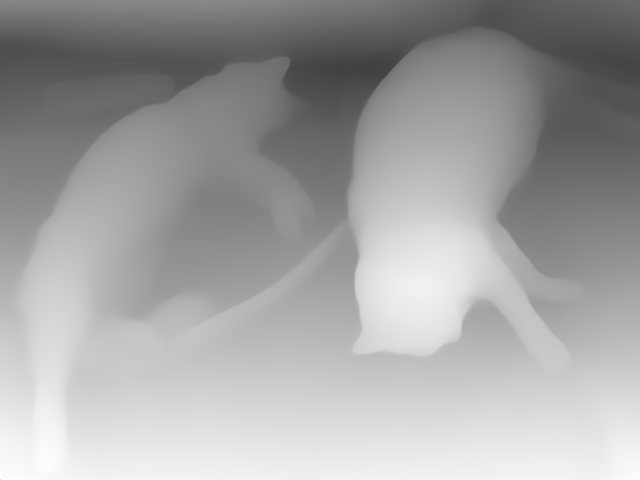

In [7]:
depth